# Purpose

- Get alerts & be able to visualize ARK investing data (Ex: What are they buying/selling, what sectors?, how has ARK been sizing into a company (eg: consistent buying as price declines?))

## End game is to answer questions:
- Alerts when they buy penny stocks (Lo-cap)

- Statistics on the following:
    - How much is the average drawdown of a position?
    - How long does it take (on average) for a position to be decently positive (>10%)?
    - ???

In [1]:
def set_dir(path=""):
    import os
    if path != "":
        os.chdir(path)
    else:
        pass #Keep directory as current working directory

In [69]:
def see_data(db=0): #Function to view the data in the database easily
    import sqlite3
    import pandas as pd
    
    set_dir()
    
    if db == 0:
        db_name = "ARKFund.db"
        db_table = "arkfunds"
    elif db == 1:
        db_name = "sectors.db"
        db_table = "sectors"
        
    conn = sqlite3.connect(db_name) #Connect
    df = pd.read_sql_query('SELECT * FROM ' + db_table,conn)
    #display(df) #Print all data
    conn.close()
    return df

In [70]:
def capitalization(ticker): #Determine cap size of company
    import finviz
    import yfinance as yf
    
    try: #finviz approach
        info = finviz.get_stock(ticker)['Market Cap'] #Get market cap

        #Split market cap to take only whole number
        l,r = info.split('.')
        valuation = int(l) #Left of the decimal place
        units = r[-1] #Units ("M" or "B")

        #Nano is less than 50M ... dont think i need to classify this though
        #Micro is anything 300M and less
        #Small is [300M,2B]
        #Mid is [2B,10B]
        #Large is everything else
        if units == "M":
            if valuation <300:
                cap = "Micro"
            else:
                cap = "Small"
        elif units == "B":
            if valuation < 2:
                cap = "Small"
            elif valuation <= 10:
                cap = "Mid"
            else:
                cap = "Large"
        elif units == "T": #Companies like AAPL are 2151B ... but just in case finviz ever updates to trillion
            cap = "Large"
        else:
            cap = "Nano" #Catch case if something else shows up ... would have to assume Nano cap
    except: #If finviz is unable to gather the information ... try yfinance
        try:
            valuation = yf.Ticker(ticker).info['marketCap']
            if valuation/1000000000>10: #Greater than 10B company
                valuation = valuation/1000000000
                cap = "Large"
                units = "B"
            elif valuation/1000000000>2: #Greater than 2B company
                valuation = valuation/1000000000
                cap = "Mid"
                units = "B"
            elif valuation/1000000000>0: #In the billion range
                valuation = valuation/1000000000
                cap = "Small"
                units = "B"
            else:
                if valuation/1000000>300: #Greater than 300M company
                    valuation = valuation/1000000
                    cap = "Small"
                    units = "M"
                else:
                    valuation = valuation/1000000
                    cap = "Micro"
                    units = "M"
            valuation = int(str(valuation).split('.')[0]) #Finalize the valuation as an integer of the whole number value
        except: #If yfinance doesnt work -- simply state "NA"
            cap = "NA"
            valuation = "NA"
            units = ""
        
    return cap,str(valuation)+units #Cap = classification | MarketCap

In [71]:
def update_sectors(df):
    '''
    Function to check if any new unique tickers exist
    -- If not, do nothing
    -- If so,
    ---- Utilize finviz to find sector info for ticker
    ---- Update the sectors.db to include this unique ticker
    '''
    import finviz
    import yfinance as yf
    import os
    import sqlite3
    import pandas as pd

    set_dir()
    
    if "sectors.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('sectors.db')

    else:
        #Create db
        conn = sqlite3.connect('sectors.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE sectors (ticker TEXT, sector TEXT, cap TEXT, market_cap INT)''')
        conn.commit() #save

    print("update_sectors():")
    print("\t--- Connection to sector db established ---")

    #Grab db info
    sector_tickers = pd.read_sql_query("SELECT * FROM sectors ORDER BY ticker",conn)
    
    if len(df) < 1: #No df to process
        #Find all unique tickers in the database
        data_to_process = False
    else:
        data_to_process = True
    
    if data_to_process:
        
        #Clean up the ticker column of dataframe
        df['ticker'] = df['ticker'].str.split().str.get(0) #Split & grab the first word of the ticker column to save as ticker
            #This converts things like "TAK UN" to "TAK" while still keeping things like "AAPL" as "AAPL"
        
        #Now find unique entries
        tickers = df['ticker'].unique() 

        missing = []
        print("\tChecking if tickers need updating")
        for i in tickers:
            if i not in sector_tickers['ticker'].unique():
                missing.append(i) #Add all new tickers to "missing"
                if len(missing) == 1: #If a new ticker is found, do a printout notification
                    print("\t\tNew tickers found")

        sector = []
        cap_designation = []
        valuation = []
        if len(missing) < 1:
            print("\t\tNo new tickers to update")
        else:
            print("\tSearching sector & capitalization info for %d tickers"%len(tickers))
            for i in missing: #For each ticker missing, attempt to find the sector for it
                print("\t\t"+i+" --- ",end='')
                try:
                    sec = finviz.get_stock(i)['Sector']
                    c,m = capitalization(i)
                except: #If finviz cannot find the information, try yfinance
                    try:
                        sec = yf.Ticker(i).info['sector']
                        c,m = capitalization(i)
                    except: #If neither can find information --- set "NA"
                        sec = "NA" #Some tickers like "8994" will not pull up a result
                        c = "NA"
                        m = "NA"
                cap_designation.append(c)
                valuation.append(m)
                sector.append(sec)
                print(sec) #Attach the sector to the printout
            
        #Update the df
        sector_tickers = sector_tickers.append(pd.DataFrame({'ticker':missing,
                                                             'sector':sector,
                                                             'cap':cap_designation,
                                                             'market_cap':valuation}),ignore_index=True)

        #Format the df a bit
        sector_tickers = sector_tickers.sort_values(by='ticker').reset_index(drop=True) #sort by ticker & reset index

        #Write to db
        sector_tickers.to_sql(name='sectors', con=conn, if_exists='replace', index=False)

        conn.commit() #Save
        print("\tSector information has been updated")
    
    #Close connections   
    conn.close()
    print("\tConnection to sectors.db has been closed")
    
    return sector_tickers

In [72]:
def backup_data():
    '''
    Run every so often to backup the ARKFunds.db and Sectors.db files
    '''
    from shutil import copyfile
    import datetime
    
    set_dir() #Make sure directory is set appropriately
    
    today = datetime.datetime.today()
    
    if today.weekday() == 4: #If day of week is Friday
        print("backup_data() activated --- backing up databases because it is Friday")
        copyfile("ARKFund.db","Backups/"+today.date().isoformat()+" ARKFund.db")
        copyfile("sectors.db","Backups/"+today.date().isoformat()+" sectors.db")
        print("\tData has been backedup for today: ",today.date().isoformat())
    else:
        pass

In [73]:
def change_in_portfolio(date1=None,date2=None,fund=None,debug=False):
    '''
    Functionality for `fund` argument built in ... but not fully tested
    '''
    import numpy as np
    import pandas as pd
    
    df = see_data(0) #Grab all data in SQL database
    unique_dates = df['date'].unique()
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object
    df = df.sort_values(by='date',ascending=True).drop(['sector','market_cap','weight'],axis=1) #Sort ascending dates & drop unnecessary columns
    
    #If no dates provided
    if date1 == None or date2 == None:
        date1 = unique_dates[-2] #Previous trading session
        date2 = unique_dates[-1] #Most recent trading session
    
    #If dates provided are short-hand .... add the year to them
    def add_year(date):
        import datetime
        year = datetime.datetime.today().year
        return date+"/"+str(year)
    if len(date1)<7:
        date1 = add_year(date1)
    if len(date2)<7:
        date2 = add_year(date2)
    
    #To account for "New" positions opened... the date BEFORE date1 needs to be referenced.
    #Ex: If a new position is opened on 1/11 ... how do you know it is new unless you can confirm from 1/10 that a position was not previously held
    loc_initial_date = np.where(np.array(unique_dates)==date1)[0][0]-1 #Minus 1 to reach the previous date
    
    if loc_initial_date == -1:
        loc_initial_date += 1 #change to 0 index if it is the first date
    
    #If no fund provided, simply search by dates
    if fund == None:
        #Grab subset info for the dates
        a = df[(df['date']==date1)]
        b = df[(df['date']==date2)]
    else:
        #Grab subset info for the specified fund
        a = df[(df['date']==date1)&(df['fund']==fund)]
        b = df[(df['date']==date2)&(df['fund']==fund)]
    
    #Compare via `how='outer'`
    diff = a.merge(b,how='outer',on=['fund','company','ticker','cap'],indicator=False) #Determine differences between the 2 dates
    diff['change'] = diff['shares_y']-diff['shares_x'] #Compute change in shares
    diff['percent_change'] = np.round(np.divide(100*diff['change'],diff['shares_x']),2)
    
    #Pick only select columns
    #diff = diff[['date_x','date_y','fund','ticker','shares_x','shares_y','change']]
    
    #Create new DF with appropriate column headers
    changes = diff.rename(columns={'shares_x':"shares_then","shares_y":"shares_now",
                                'date_x':"start_date","date_y":"end_date"}) #Rename for clarity
    changes = changes[['start_date','end_date','fund','company','ticker','shares_then','shares_now','change','percent_change','cap']]
    changes = changes[changes['change']!=0] #Drop any rows which have no action (ie: Change = 0 because no change in shares)
    
    ###Determine positions that are new
    new = changes[pd.isna(changes['shares_then'])] #All positions which didn't have shares before are new
    
    # Compute a sliced df containing only dates between [date1,date2] for use in `new` and `closed` dfs
    #Subset the original df to be between these 2 dates
    df = df[(df['date']>=unique_dates[loc_initial_date])&(df['date']<=date2)] #This new df is used to compute new & closed positions
    
    #Compute the date these positions opened
    initiation_date = []
    for i,row in new.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find this subset in the sliced [date1,date2] df
        initiation_date.append(subset.iloc[0]['date'])

    new = new[['fund','ticker','shares_now']] #Drop the useless information (NaN columns)
    new = new.rename(columns={'shares_now':'shares_initiated'}) #rename column
    new['initiation_date'] = initiation_date #Create a new column with the date of position start
    new = new.sort_values(by='initiation_date',ascending=False) #Sort df by open dates
    
    ###Determine positions that closed
    closed = diff[pd.isna(diff['shares_y'])==True] #All positions which no longer have shares on today's date are closed
    #Determine date the position(s) were closed
    sell_date = []
    for _,row in closed.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find all instances of the closed ticker position
        sell_date.append(subset['date'].iloc[-1]) #The final entry's date is the close date

    closed = closed[['fund','ticker','shares_x']].rename(columns={'shares_x':"shares_before_sale"}) #Drop unnecessary columns
    closed['close_date'] = sell_date #Create column
    closed = closed.sort_values(by='close_date',ascending=False) #Sort data
    
    ##Update Change df to not include new or closed positions
    #The rows that would exist in "new" and "closed" are present in "changes" as well -- eliminate by finding all non-NaN entries
    changes = changes[pd.isna(changes['change'])==False] #Make the "changes" df have all changes that arent new/closed

    ##Determine what are `significant` transactions to keep an eye on
    alerts = changes.copy() #Copy the df
    changes = changes.drop(['cap','company'],axis=1) #Drop the last few columns on Change column that arent necessary
    alerts = alerts[(np.abs(alerts['percent_change'])>=10)|((np.abs(alerts['percent_change'])>=4.5)&(alerts['cap']=='Small'))].sort_values(by=['percent_change'],ascending=False).reset_index(drop=True)
    
    if debug: #Just making a quick method to print all 4 df results accordingly
        print("dates:")
        print(date1,date2)
        print("Changes:")
        display(changes)
        print("New positions:")
        display(new)
        print("Closed positions:")
        display(closed)
        print("Alerts:")
        display(alerts)
    
    return changes, new, closed, alerts

In [22]:
def update_capitalization(manual_update=False):
    """
    Function to update capitalization & market cap for ALL stocks in the database
    Recommend running once in a while ... maybe once a week?
    
    Why run this?
    Companies may break the barrier from Small -> Mid or drop from Mid -> Small (since the bound is only 2B to 10B for small)
    """
    import pandas as pd
    import numpy as np
    import sqlite3
    import datetime
    
    today = datetime.datetime.today().weekday()
    
    #Check if "update_capitalization" has run today by checking if today's date exists in the checkbox.csv file
    now = datetime.datetime.now()
    d = pd.read_csv('Logs/capitalization_checkbox.csv') #Read the file
    date_now = now.strftime("%m/%d/%Y") #Convert today's date to "MM/DD/YYYY" format

    if manual_update == True: #If manual updating ... update the log
        if date_now in d['date'].values:
            go_ahead = False #If already in there, don't update
        else:
            go_ahead = True #Else update
    
    if manual_update=="disable":
        pass
    else:
        if today == 4 or go_ahead==True: #go_ahead will only be instated if manual_update==True 
            
            #Check if today's date exists already
            if date_now in d['date'].values:
                print("Date already exists -- manual updating request denied")
                go_ahead = False #If so, don't execute again
            else:
                d = d.append({'date':date_now,'ran':'yes'},ignore_index=True) #If not, update the file and run capitalization update
                d.to_csv("Logs/capitalization_checkbox.csv",index=False) #Write the file
                go_ahead = True
            
            if go_ahead == True: #manual_update==True disregards both 
                print("update_capitalization():")
                print("\tUpdating capitalization information for entire database")
                conn = sqlite3.connect("ARKFund.db")
                conn2 = sqlite3.connect("sectors.db")
                df = pd.read_sql_query("SELECT * FROM arkfunds",conn)
                print("\tConnection to ARKFund.db established")
                sectors = pd.read_sql_query("SELECT * FROM sectors",conn2)
                print("\tConnection to sectors.db established")

                #Create placeholder lists
                c = [] #Cap designation (Eg: Small)
                m = [] #Market cap value (Eg: 1B)

                count = 0
                total = len(sectors['ticker'])
                print("\tUpdating %s tickers:"%total)
                for i in sectors['ticker']:
                    if count%40 == 0: #Every 40 rows, update the progress
                        print("\t\t%.2f/100%%"%(np.round(count/total,2)*100))
                    try:
                        cap_designation,market_cap = capitalization(i)
                    except:
                        cap_designation,market_cap = ["NA","NA"]
                    c.append(cap_designation)
                    m.append(market_cap)
                    count += 1

                print("\t\tDone finding capitalizations -- Merging to `sectors` database")
                sectors['cap'] = c
                sectors['market_cap'] = m

                print("\tWriting results to sectors.db")
                sectors.to_sql(name='sectors',con=conn2,if_exists='replace',index=False)
                print("\t\tSectors.db updated successfully")

                #Create dictionaries to map (Ticker --> Cap) and (Ticker --> Market_cap)
                dct_cap = dict(sectors[['ticker','cap']].to_dict('split')['data']) # dct of {'AAPL':'Large', ... , 'ZM':'Large'}
                dct_market_cap = dict(sectors[['ticker','market_cap']].to_dict('split')['data']) #dct of {'AAPL':'2180B', ... , 'ZM':'114B'}

                df = df.drop(['cap','market_cap'],axis=1) #Drop the cap and market_cap columns because we'll be updating them

                #Re-create the columns via mapping
                df['cap'] = df['ticker'].map(dict(dct_cap))
                df['market_cap'] = df['ticker'].map(dict(dct_market_cap))

                print("\tWriting results to ARKFunds.db")
                df.to_sql(name='arkfunds', con=conn, if_exists="replace", index=False)
                print("\t\tARKFund.db updated successfully")

                #Now actually save the data (even though printouts have been saying its been successful)
                conn.commit()
                conn2.commit()

                conn.close()
                conn2.close()
                print("\tDatabase connections closed successfully")
        else:
            pass #Dont execute unless it's Friday

In [75]:
def update_arkfund(display_changes=False,manual_update=False,path = r"C:\Users\Brandon\Desktop\ARK Fund CSV Files"):
    import glob
    import os
    import sqlite3
    import pandas as pd
    import finviz
    
    #Change directory
    set_dir(path=path)

    #Load all excel files & Concat together
    files = glob.glob("*.csv") #Find all

    if "ARKFund.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('ARKFund.db')

        #Create cursor object
        c = conn.cursor()
    else:
        #Create db
        conn = sqlite3.connect('ARKFund.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE arkfunds 
            (date TEXT, fund TEXT, company TEXT, ticker TEXT, shares INTEGER, weight REAL, sector TEXT,cap TEXT, market_cap INT)
                ''')
        conn.commit() #save

    print("--- Connection to ARKFunds.db established ---")

    print("Processing %.0f files:"%len(files))

    existing_files = glob.glob("Processed\*.csv")
    existing_files = [i[10:] for i in existing_files]
    
    df_all = pd.DataFrame()
    new_data=False #Set default switch
    for file in files:
        if file not in existing_files:
            df = pd.read_csv(file) #Read csv file
            df_all = df_all.append(df) #Append to mega df
            new_data=True
        else:
            print("\t%s already exists in the database -- Removing file"%file)
            os.remove(file)
            print("File: %s has been deleted"%file)            
            
    if new_data: #If there is data to process
        #Grab sector info
        #1) Check if there are any new unique tickers that havent existed before
        #2) Grab the info if new tickers
        
        #Clean up the ticker column of dataframe
        df_all['ticker'] = df_all['ticker'].str.split().str.get(0) #Split & grab the first word of the ticker column to save as ticker
            #This converts things like "TAK UN" to "TAK" while still keeping things like "AAPL" as "AAPL"
        
        sectors = update_sectors(df_all) #Use the function to update any ticker that didnt exist AND obtain df of [ticker,sector]
        
        #Match "Ticker" in arkfunds.db to "sector" from sectors.db
        sec = []
        for i in df_all['ticker']:
            try:
                sec.append(sectors[sectors['ticker']==i]['sector'].iloc[0])
            except:
                sec.append("NA")
        print("Updating ARKfund with Sector.db info")
        df_all['sector'] = sec #create a new column called "sector" by matching the `ticker` to `sector`
        
        #Convert date column into datetime object 
        #df_all['date'] = df_all['date'].astype("datetime64[ns]") 
        ###Does not work! -- SQLite3 can only accept types TEXT, INT, REAL ... this results in datetime --> TEXT upon saving
        
        print("Computing capitalization of new data")
        #Do this by loading in sectors.db data and grabbing the data from there (already loaded as sectors)
        cap_designation = []
        valuation = []
        count = 2
        total = len(df_all['ticker'])
        for i in df_all['ticker']: 
            if count%50 == 0 or count == total: #Provide progress updates
                print("\t%s/%s"%(count,total))
            temp = sectors[sectors['ticker']==i]
            cap_designation.append(temp['cap'].iloc[0])
            valuation.append(temp['market_cap'].iloc[0])
            count += 1
        
        df_all['cap'] = cap_designation
        df_all['market_cap'] = valuation
        
        #Rename 'weight(%)' to 'weight'
        print("Renaming weight(%) to weight")
        df_all = df_all.rename(columns={"weight(%)":"weight"})

        #Update ARKFunds.db database
        print("Writing results to database")
        df_all.to_sql(name='arkfunds', con=conn, if_exists='append', index=False)

        conn.commit() #Save database
        
        #Now that all the work has been done, move the files (do this last to avoid double entry of files)
        for file in files:
            os.rename(file, "Processed/"+file) #Move csv file to the processed folder so it doesn't read next time
            print("\t%s has been uploaded"%file)
    else:
        print("No new data to process")
        sectors = see_data(1) #Grab sectors data to provide as output

    conn.close() #Close SQLite Database connection
    print("--- Connection closed ---")
    print("SQL Database has been successfully updated.")
    
    #Backup servers as necessary (Current trigger is: Friday (weekday == 4))
    update_capitalization(manual_update=manual_update) #Updates all info for sectors.db then ARKFund.db ... a bit redundant because we just loaded data today (but runs quite fast)
    backup_data() #function checks weekday and returns nothing if weekday != 4 ... it backs up both ".db" files
    
    changes, new, closed, alerts = change_in_portfolio() #Determine changes, new positions, closed positions, alerts
    store_logs(changes,new,closed,alerts)
    if display_changes:
        print("New positions:")
        display(new)
        print("Closed positions:")
        display(closed)
        print("Alerts:")
        display(alerts)
        
    return df_all,sectors, changes, new, closed, alerts #df_all = df of newly appended data .. NOT the data in arkfunds.db | sectors = sector all info from sectors.db

In [76]:
def store_logs(changes,new,closed,alerts):
    '''
    function to save closed, opened, and changes to .csv output
    
    reasoning:
        -A closed position may not remain closed ... it may re-open in the future
            -These would be captured once as a closed ... but not necessarily an opened position in the future (may need to adjust code when that happens)
    '''
    import datetime
    import pandas as pd
    set_dir()
    
    #Define some parameters
    d = datetime.datetime.today().date()
    base = str(d.year) + "-" + str(d.month) + "-" + str(d.day)
    dirr = "Logs/"
    dirr2 = "Logs/alerts/"
    dirr3 = "Logs/changes/"
    
    #Load in previous logs for new & closed positions
    df_new = pd.read_csv(r"Logs\new_positions.csv")
    df_closed = pd.read_csv(r"Logs\closed_positions.csv")
    
    #Need to convert str to datetime64[ns]
    df_new['initiation_date'] = df_new['initiation_date'].astype('datetime64[ns]')
    df_closed['close_date'] = df_closed['close_date'].astype('datetime64[ns]')
    
    #Append data together
    new = new.append(df_new).sort_values(by='initiation_date',ascending=False)
    closed = closed.append(df_closed).sort_values(by='close_date',ascending=False)
    
    #Delete any duplicate entries
    new = new.drop_duplicates(ignore_index=True)
    closed = closed.drop_duplicates(ignore_index=True)
    
    #Changes and alert can just be regularly updated (because I'll have a log date associated to these files)
    changes.to_csv(dirr3 + base+" changes.csv",index=False)
    alerts.to_csv(dirr2 + base + " alerts.csv",index=False)    
    new.to_csv(dirr + "new_positions.csv",index=False)
    closed.to_csv(dirr + "closed_positions.csv",index=False)
    print("Daily changes, new/closed, and alert positions have been saved")

#changes,new,closed,alerts = change_in_portfolio('1/4','1/22')
#store_logs(changes,new,closed,alerts)

In [77]:
def compute_transactions(ticker,start_date,end_date):
    transaction_log = see_data() #Grab all data
    
    #Filter by ticker
    transaction_log = transaction_log[transaction_log['ticker']==ticker]
    
    #Filter by date
    transaction_log['date'] = transaction_log['date'].astype("datetime64[ns]")
    transaction_log = transaction_log[(transaction_log['date']>=start_date)&(transaction_log['date']<=end_date)]
    
    #Grab only select columns & sort by fund then date
    transaction_log = transaction_log[['date','fund','shares','weight']].sort_values(by=['fund','date'])

    #Compute transactions
    transactions=[]
    for fund,subset in transaction_log.groupby('fund'):
        transactions.append(subset['shares'].diff().values) #Compute difference in share price each day per fund

    #Flatten the list of lists and create column from that information
    transaction_log['change_in_shares'] = [item for sublist in transactions for item in sublist]
    
    #Clean up transactions
    transaction_log = transaction_log.dropna() #Drop NaN values (initialization of position)
    transaction_log = transaction_log[transaction_log['change_in_shares']!=0] #Drop 0's as they mean no transaction occured
    
    #Rename 'shares' to 'total_shares'
    transaction_log = transaction_log.rename(columns={'shares':'shares_after_transaction'})
    
    #Reorganize columns
    transaction_log = transaction_log[['date','fund','weight','change_in_shares','shares_after_transaction']]
    
    return transaction_log

#Test script 
#t = compute_transactions("TREE","2021-01-04","2021-01-22")

In [78]:
def ticker_lookup_dash(tickers,date1=None,date2=None,together=True,funds=None):
    '''
    This version of `ticker_lookup` instead only returns the dataframe (no plot)
    
    Dash cannot use matplotlib plots =/
    '''
    import pandas as pd
    import datetime
    import numpy as np
    
    if type(tickers)==str:
        tickers = [tickers]
    
    #load & sort data
    df = see_data() #Grab all data in ARKFund.db
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object so data can be sorted
    df = df.sort_values(['date','fund'],ascending=True) #Sort by ascending date

    #If a date or dates are provided, truncate the search
    if date1 is not None:
        if date2 is None:
            df = df[df['date']>=date1]
        else:
            df = df[(df['date']>=date1)&(df['date']<=date2)]

    def log_reduction(val): #Reduce the y-axis by a factor of X
        import numpy as np
        reduced = [np.round(i/1000,2) for i in val] #Reduce share size by factor of 1000
        return reduced
    def timestamp_to_MonthDay(lst): #Convert "2021-01-14 00:00:00" to "01/14" for all elements in a list
        return [i.strftime("%m/%d") for i in lst]
    
    all_df = pd.DataFrame()
    for ticker in tickers:
        subset = df[df['ticker']==ticker.upper()].groupby('fund')
        for _,r in subset:
            #shares = log_reduction(r['shares'])
            shares = r['shares']
            dates = timestamp_to_MonthDay(r['date']) #This converts the correct x-axis from [0,1,2,...,n] to appropriate labels                
            all_df = all_df.append(pd.DataFrame({'fund':r['fund'],'date':dates,'shares':shares})) #df to return in case its useful
    return df,all_df

#Test script
#a = ticker_lookup_dash('SI') 

Write all functions to a .py file to import and use 

In [17]:
%%writefile ARK.py
def set_dir(path=""):
    import os
    if path != "":
        os.chdir(path)
    else:
        pass #Keep directory as current working directory

def see_data(db=0): #Function to view the data in the database easily
    import sqlite3
    import pandas as pd
    
    set_dir()
    
    if db == 0:
        db_name = "ARKFund.db"
        db_table = "arkfunds"
    elif db == 1:
        db_name = "sectors.db"
        db_table = "sectors"
        
    conn = sqlite3.connect(db_name) #Connect
    df = pd.read_sql_query('SELECT * FROM ' + db_table,conn)
    #display(df) #Print all data
    conn.close()
    return df

def capitalization(ticker): #Determine cap size of company
    import finviz
    import yfinance as yf
    
    try: #finviz approach
        info = finviz.get_stock(ticker)['Market Cap'] #Get market cap

        #Split market cap to take only whole number
        l,r = info.split('.')
        valuation = int(l) #Left of the decimal place
        units = r[-1] #Units ("M" or "B")

        #Nano is less than 50M ... dont think i need to classify this though
        #Micro is anything 300M and less
        #Small is [300M,2B]
        #Mid is [2B,10B]
        #Large is everything else
        if units == "M":
            if valuation <300:
                cap = "Micro"
            else:
                cap = "Small"
        elif units == "B":
            if valuation < 2:
                cap = "Small"
            elif valuation <= 10:
                cap = "Mid"
            else:
                cap = "Large"
        elif units == "T": #Companies like AAPL are 2151B ... but just in case finviz ever updates to trillion
            cap = "Large"
        else:
            cap = "Nano" #Catch case if something else shows up ... would have to assume Nano cap
    except: #If finviz is unable to gather the information ... try yfinance
        try:
            valuation = yf.Ticker(ticker).info['marketCap']
            if valuation/1000000000>10: #Greater than 10B company
                valuation = valuation/1000000000
                cap = "Large"
                units = "B"
            elif valuation/1000000000>2: #Greater than 2B company
                valuation = valuation/1000000000
                cap = "Mid"
                units = "B"
            elif valuation/1000000000>0: #In the billion range
                valuation = valuation/1000000000
                cap = "Small"
                units = "B"
            else:
                if valuation/1000000>300: #Greater than 300M company
                    valuation = valuation/1000000
                    cap = "Small"
                    units = "M"
                else:
                    valuation = valuation/1000000
                    cap = "Micro"
                    units = "M"
            valuation = int(str(valuation).split('.')[0]) #Finalize the valuation as an integer of the whole number value
        except: #If yfinance doesnt work -- simply state "NA"
            cap = "NA"
            valuation = "NA"
            units = ""
        
    return cap,str(valuation)+units #Cap = classification | MarketCap

def update_sectors(df):
    '''
    Function to check if any new unique tickers exist
    -- If not, do nothing
    -- If so,
    ---- Utilize finviz to find sector info for ticker
    ---- Update the sectors.db to include this unique ticker
    '''
    import finviz
    import yfinance as yf
    import os
    import sqlite3
    import pandas as pd

    set_dir()
    
    if "sectors.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('sectors.db')

    else:
        #Create db
        conn = sqlite3.connect('sectors.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE sectors (ticker TEXT, sector TEXT, cap TEXT, market_cap INT)''')
        conn.commit() #save

    print("update_sectors():")
    print("\t--- Connection to sector db established ---")

    #Grab db info
    sector_tickers = pd.read_sql_query("SELECT * FROM sectors ORDER BY ticker",conn)
    
    if len(df) < 1: #No df to process
        #Find all unique tickers in the database
        data_to_process = False
    else:
        data_to_process = True
    
    if data_to_process:
        
        #Clean up the ticker column of dataframe
        df['ticker'] = df['ticker'].str.split().str.get(0) #Split & grab the first word of the ticker column to save as ticker
            #This converts things like "TAK UN" to "TAK" while still keeping things like "AAPL" as "AAPL"
        
        #Now find unique entries
        tickers = df['ticker'].unique() 

        missing = []
        print("\tChecking if tickers need updating")
        for i in tickers:
            if i not in sector_tickers['ticker'].unique():
                missing.append(i) #Add all new tickers to "missing"
                if len(missing) == 1: #If a new ticker is found, do a printout notification
                    print("\t\tNew tickers found")

        sector = []
        cap_designation = []
        valuation = []
        if len(missing) < 1:
            print("\t\tNo new tickers to update")
        else:
            print("\tSearching sector & capitalization info for %d tickers"%len(tickers))
            for i in missing: #For each ticker missing, attempt to find the sector for it
                print("\t\t"+i+" --- ",end='')
                try:
                    sec = finviz.get_stock(i)['Sector']
                    c,m = capitalization(i)
                except: #If finviz cannot find the information, try yfinance
                    try:
                        sec = yf.Ticker(i).info['sector']
                        c,m = capitalization(i)
                    except: #If neither can find information --- set "NA"
                        sec = "NA" #Some tickers like "8994" will not pull up a result
                        c = "NA"
                        m = "NA"
                cap_designation.append(c)
                valuation.append(m)
                sector.append(sec)
                print(sec) #Attach the sector to the printout
            
        #Update the df
        sector_tickers = sector_tickers.append(pd.DataFrame({'ticker':missing,
                                                             'sector':sector,
                                                             'cap':cap_designation,
                                                             'market_cap':valuation}),ignore_index=True)

        #Format the df a bit
        sector_tickers = sector_tickers.sort_values(by='ticker').reset_index(drop=True) #sort by ticker & reset index

        #Write to db
        sector_tickers.to_sql(name='sectors', con=conn, if_exists='replace', index=False)

        conn.commit() #Save
        print("\tSector information has been updated")
    
    #Close connections   
    conn.close()
    print("\tConnection to sectors.db has been closed")
    
    return sector_tickers

def backup_data():
    '''
    Run every so often to backup the ARKFunds.db and Sectors.db files
    '''
    from shutil import copyfile
    import datetime
    
    set_dir() #Make sure directory is set appropriately
    
    today = datetime.datetime.today()
    
    if today.weekday() == 4: #If day of week is Friday
        print("backup_data() activated --- backing up databases because it is Friday")
        copyfile("ARKFund.db","Backups/"+today.date().isoformat()+" ARKFund.db")
        copyfile("sectors.db","Backups/"+today.date().isoformat()+" sectors.db")
        print("\tData has been backedup for today: ",today.date().isoformat())
    else:
        pass     #Backup both ".db" files (executes on Friday)

def change_in_portfolio(date1=None,date2=None,fund=None,debug=False):
    '''
    Functionality for `fund` argument built in ... but not fully tested
    '''
    import numpy as np
    import pandas as pd
    
    df = see_data(0) #Grab all data in SQL database
    unique_dates = df['date'].unique()
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object
    df = df.sort_values(by='date',ascending=True).drop(['sector','market_cap','weight'],axis=1) #Sort ascending dates & drop unnecessary columns
    
    #If no dates provided
    if date1 == None or date2 == None:
        date1 = unique_dates[-2] #Previous trading session
        date2 = unique_dates[-1] #Most recent trading session
    
    #If dates provided are short-hand .... add the year to them
    def add_year(date):
        import datetime
        year = datetime.datetime.today().year
        return date+"/"+str(year)
    if len(date1)<7:
        date1 = add_year(date1)
    if len(date2)<7:
        date2 = add_year(date2)
    
    #To account for "New" positions opened... the date BEFORE date1 needs to be referenced.
    #Ex: If a new position is opened on 1/11 ... how do you know it is new unless you can confirm from 1/10 that a position was not previously held
    loc_initial_date = np.where(np.array(unique_dates)==date1)[0][0]-1 #Minus 1 to reach the previous date
    
    if loc_initial_date == -1:
        loc_initial_date += 1 #change to 0 index if it is the first date
    
    #If no fund provided, simply search by dates
    if fund == None:
        #Grab subset info for the dates
        a = df[(df['date']==date1)]
        b = df[(df['date']==date2)]
    else:
        #Grab subset info for the specified fund
        a = df[(df['date']==date1)&(df['fund']==fund)]
        b = df[(df['date']==date2)&(df['fund']==fund)]
    
    #Compare via `how='outer'`
    diff = a.merge(b,how='outer',on=['fund','company','ticker','cap'],indicator=False) #Determine differences between the 2 dates
    diff['change'] = diff['shares_y']-diff['shares_x'] #Compute change in shares
    diff['percent_change'] = np.round(np.divide(100*diff['change'],diff['shares_x']),2)
    
    #Pick only select columns
    #diff = diff[['date_x','date_y','fund','ticker','shares_x','shares_y','change']]
    
    #Create new DF with appropriate column headers
    changes = diff.rename(columns={'shares_x':"shares_then","shares_y":"shares_now",
                                'date_x':"start_date","date_y":"end_date"}) #Rename for clarity
    changes = changes[['start_date','end_date','fund','company','ticker','shares_then','shares_now','change','percent_change','cap']]
    changes = changes[changes['change']!=0] #Drop any rows which have no action (ie: Change = 0 because no change in shares)
    
    ###Determine positions that are new
    new = changes[pd.isna(changes['shares_then'])] #All positions which didn't have shares before are new
    
    # Compute a sliced df containing only dates between [date1,date2] for use in `new` and `closed` dfs
    #Subset the original df to be between these 2 dates
    df = df[(df['date']>=unique_dates[loc_initial_date])&(df['date']<=date2)] #This new df is used to compute new & closed positions
    
    #Compute the date these positions opened
    initiation_date = []
    for i,row in new.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find this subset in the sliced [date1,date2] df
        initiation_date.append(subset.iloc[0]['date'])

    new = new[['fund','ticker','shares_now']] #Drop the useless information (NaN columns)
    new = new.rename(columns={'shares_now':'shares_initiated'}) #rename column
    new['initiation_date'] = initiation_date #Create a new column with the date of position start
    new = new.sort_values(by='initiation_date',ascending=False) #Sort df by open dates
    
    ###Determine positions that closed
    closed = diff[pd.isna(diff['shares_y'])==True] #All positions which no longer have shares on today's date are closed
    #Determine date the position(s) were closed
    sell_date = []
    for _,row in closed.iterrows():
        subset = df[(df['ticker']==row['ticker'])&(df['fund']==row['fund'])] #Find all instances of the closed ticker position
        sell_date.append(subset['date'].iloc[-1]) #The final entry's date is the close date

    closed = closed[['fund','ticker','shares_x']].rename(columns={'shares_x':"shares_before_sale"}) #Drop unnecessary columns
    closed['close_date'] = sell_date #Create column
    closed = closed.sort_values(by='close_date',ascending=False) #Sort data
    
    ##Update Change df to not include new or closed positions
    #The rows that would exist in "new" and "closed" are present in "changes" as well -- eliminate by finding all non-NaN entries
    changes = changes[pd.isna(changes['change'])==False] #Make the "changes" df have all changes that arent new/closed

    ##Determine what are `significant` transactions to keep an eye on
    alerts = changes.copy() #Copy the df
    changes = changes.drop(['cap','company'],axis=1) #Drop the last few columns on Change column that arent necessary
    alerts = alerts[(np.abs(alerts['percent_change'])>=10)|((np.abs(alerts['percent_change'])>=4.5)&(alerts['cap']=='Small'))].sort_values(by=['percent_change'],ascending=False).reset_index(drop=True)
    
    if debug: #Just making a quick method to print all 4 df results accordingly
        print("dates:")
        print(date1,date2)
        print("Changes:")
        display(changes)
        print("New positions:")
        display(new)
        print("Closed positions:")
        display(closed)
        print("Alerts:")
        display(alerts)
    
    return changes, new, closed, alerts
    
def update_capitalization(manual_update=False):
    """
    Function to update capitalization & market cap for ALL stocks in the database
    Recommend running once in a while ... maybe once a week?
    
    Why run this?
    Companies may break the barrier from Small -> Mid or drop from Mid -> Small (since the bound is only 2B to 10B for small)
    """
    import pandas as pd
    import numpy as np
    import sqlite3
    import datetime
    
    today = datetime.datetime.today().weekday()
    
    #Check if "update_capitalization" has run today by checking if today's date exists in the checkbox.csv file
    now = datetime.datetime.now()
    d = pd.read_csv('Logs/capitalization_checkbox.csv') #Read the file
    date_now = now.strftime("%m/%d/%Y") #Convert today's date to "MM/DD/YYYY" format

    go_ahead = False #Set boolean value
    if manual_update == True: #If manual updating ... update the log
        if date_now in d['date'].values:
            print("Date already exists -- manual updating request denied")
        else:
            go_ahead = True #Else update
    
    if manual_update=="disable": #'disable' feature is kind of usless now that the checkbox.csv file exists, oh well~
        pass
    else:
        if today == 4 or go_ahead==True:
            
            #Check if today's date exists already
            if date_now in d['date'].values:
                go_ahead = False #If so, don't execute again
            else:
                d = d.append({'date':date_now,'ran':'yes'},ignore_index=True) #If not, update the file and run capitalization update
                d.to_csv("Logs/capitalization_checkbox.csv",index=False) #Write the file
                go_ahead = True
            
            if go_ahead == True: #manual_update==True disregards both 
                print("update_capitalization():")
                print("\tUpdating capitalization information for entire database")
                conn = sqlite3.connect("ARKFund.db")
                conn2 = sqlite3.connect("sectors.db")
                df = pd.read_sql_query("SELECT * FROM arkfunds",conn)
                print("\tConnection to ARKFund.db established")
                sectors = pd.read_sql_query("SELECT * FROM sectors",conn2)
                print("\tConnection to sectors.db established")

                #Create placeholder lists
                c = [] #Cap designation (Eg: Small)
                m = [] #Market cap value (Eg: 1B)

                count = 0
                total = len(sectors['ticker'])
                print("\tUpdating %s tickers:"%total)
                for i in sectors['ticker']:
                    if count%25 == 0: #Every 25 rows, update the progress
                        print("\t\t%.2f/100%%"%(np.round(count/total,2)*100))
                    try:
                        cap_designation,market_cap = capitalization(i)
                    except:
                        cap_designation,market_cap = ["NA","NA"]
                    c.append(cap_designation)
                    m.append(market_cap)
                    count += 1

                print("\t\tDone finding capitalizations -- Merging to `sectors` database")
                sectors['cap'] = c
                sectors['market_cap'] = m

                print("\tWriting results to sectors.db")
                sectors.to_sql(name='sectors',con=conn2,if_exists='replace',index=False)
                print("\t\tSectors.db updated successfully")

                #Create dictionaries to map (Ticker --> Cap) and (Ticker --> Market_cap)
                dct_cap = dict(sectors[['ticker','cap']].to_dict('split')['data']) # dct of {'AAPL':'Large', ... , 'ZM':'Large'}
                dct_market_cap = dict(sectors[['ticker','market_cap']].to_dict('split')['data']) #dct of {'AAPL':'2180B', ... , 'ZM':'114B'}

                df = df.drop(['cap','market_cap'],axis=1) #Drop the cap and market_cap columns because we'll be updating them

                #Re-create the columns via mapping
                df['cap'] = df['ticker'].map(dict(dct_cap))
                df['market_cap'] = df['ticker'].map(dict(dct_market_cap))

                print("\tWriting results to ARKFunds.db")
                df.to_sql(name='arkfunds', con=conn, if_exists="replace", index=False)
                print("\t\tARKFund.db updated successfully")

                #Now actually save the data (even though printouts have been saying its been successful)
                conn.commit()
                conn2.commit()

                conn.close()
                conn2.close()
                print("\tDatabase connections closed successfully")
        else:
            pass #Dont execute unless it's Friday
        
def ticker_lookup_dash(tickers,date1=None,date2=None,together=True,funds=None):
    '''
    This version of `ticker_lookup` instead only returns the dataframe (no plot)
    
    Dash cannot use matplotlib plots =/
    '''
    import pandas as pd
    import datetime
    import numpy as np
    
    if type(tickers)==str:
        tickers = [tickers]
    
    #load & sort data
    df = see_data() #Grab all data in ARKFund.db
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object so data can be sorted
    df = df.sort_values(['date','fund'],ascending=True) #Sort by ascending date

    #If a date or dates are provided, truncate the search
    if date1 is not None:
        if date2 is None:
            df = df[df['date']>=date1]
        else:
            df = df[(df['date']>=date1)&(df['date']<=date2)]

    def log_reduction(val): #Reduce the y-axis by a factor of X
        import numpy as np
        reduced = [np.round(i/1000,2) for i in val] #Reduce share size by factor of 1000
        return reduced
    def timestamp_to_MonthDay(lst): #Convert "2021-01-14 00:00:00" to "01/14" for all elements in a list
        return [i.strftime("%m/%d") for i in lst]
    
    all_df = pd.DataFrame()
    for ticker in tickers:
        subset = df[df['ticker']==ticker.upper()].groupby('fund')
        for _,r in subset:
            #shares = log_reduction(r['shares'])
            shares = r['shares']
            dates = timestamp_to_MonthDay(r['date']) #This converts the correct x-axis from [0,1,2,...,n] to appropriate labels                
            all_df = all_df.append(pd.DataFrame({'fund':r['fund'],'date':dates,'shares':shares})) #df to return in case its useful
    return all_df
    
def store_logs(changes,new,closed,alerts):
    '''
    function to save closed, opened, and changes to .csv output
    
    reasoning:
        -A closed position may not remain closed ... it may re-open in the future
            -These would be captured once as a closed ... but not necessarily an opened position in the future (may need to adjust code when that happens)
    '''
    import datetime
    import pandas as pd
    set_dir()
    
    #Define some parameters
    d = datetime.datetime.today().date()
    base = str(d.year) + "-" + str(d.month) + "-" + str(d.day)
    dirr = "Logs/"
    dirr2 = "Logs/alerts/"
    dirr3 = "Logs/changes/"
    
    #Load in previous logs for new & closed positions
    df_new = pd.read_csv(r"Logs\new_positions.csv")
    df_closed = pd.read_csv(r"Logs\closed_positions.csv")
    
    #Need to convert str to datetime64[ns]
    df_new['initiation_date'] = df_new['initiation_date'].astype('datetime64[ns]')
    df_closed['close_date'] = df_closed['close_date'].astype('datetime64[ns]')
    
    #Append data together
    new = new.append(df_new).sort_values(by='initiation_date',ascending=False)
    closed = closed.append(df_closed).sort_values(by='close_date',ascending=False)
    
    #Delete any duplicate entries
    new = new.drop_duplicates(ignore_index=True)
    closed = closed.drop_duplicates(ignore_index=True)
    
    #Changes and alert can just be regularly updated (because I'll have a log date associated to these files)
    changes.to_csv(dirr3 + base+" changes.csv",index=False)
    alerts.to_csv(dirr2 + base + " alerts.csv",index=False)    
    new.to_csv(dirr + "new_positions.csv",index=False)
    closed.to_csv(dirr + "closed_positions.csv",index=False)
    print("Daily changes, new/closed, and alert positions have been saved")
    
def compute_transactions(ticker,start_date,end_date):
    transaction_log = see_data() #Grab all data
    
    #Filter by ticker
    transaction_log = transaction_log[transaction_log['ticker']==ticker]
    
    #Filter by date
    transaction_log['date'] = transaction_log['date'].astype("datetime64[ns]")
    transaction_log = transaction_log[(transaction_log['date']>=start_date)&(transaction_log['date']<=end_date)]
    
    #Grab only select columns & sort by fund then date
    transaction_log = transaction_log[['date','fund','shares','weight']].sort_values(by=['fund','date'])

    #Compute transactions
    transactions=[]
    for fund,subset in transaction_log.groupby('fund'):
        transactions.append(subset['shares'].diff().values) #Compute difference in share price each day per fund

    #Flatten the list of lists and create column from that information
    transaction_log['change_in_shares'] = [item for sublist in transactions for item in sublist]
    
    #Clean up transactions
    transaction_log = transaction_log.dropna() #Drop NaN values (initialization of position)
    transaction_log = transaction_log[transaction_log['change_in_shares']!=0] #Drop 0's as they mean no transaction occured
    
    #Rename 'shares' to 'total_shares'
    transaction_log = transaction_log.rename(columns={'shares':'shares_after_transaction'})
    
    #Reorganize columns
    transaction_log = transaction_log[['date','fund','weight','change_in_shares','shares_after_transaction']]
    
    return transaction_log
      
def update_arkfund(display_changes=False,manual_update=False,path = r"C:\Users\Brandon\Desktop\ARK Fund CSV Files"):
    import glob
    import os
    import sqlite3
    import pandas as pd
    import finviz
    
    #Change directory
    set_dir(path=path)

    #Load all excel files & Concat together
    files = glob.glob("*.csv") #Find all

    if "ARKFund.db" in os.listdir():
        #Connect to db
        conn = sqlite3.connect('ARKFund.db')

        #Create cursor object
        c = conn.cursor()
    else:
        #Create db
        conn = sqlite3.connect('ARKFund.db') #Yes ... its the same line of code to connect or create

        #Create cursor
        c = conn.cursor()

        #Define table structure
        c.execute('''CREATE TABLE arkfunds 
            (date TEXT, fund TEXT, company TEXT, ticker TEXT, shares INTEGER, weight REAL, sector TEXT,cap TEXT, market_cap INT)
                ''')
        conn.commit() #save

    print("--- Connection to ARKFunds.db established ---")

    print("Processing %.0f files:"%len(files))

    existing_files = glob.glob("Processed\*.csv")
    existing_files = [i[10:] for i in existing_files]
    
    df_all = pd.DataFrame()
    new_data=False #Set default switch
    for file in files:
        if file not in existing_files:
            df = pd.read_csv(file) #Read csv file
            df_all = df_all.append(df) #Append to mega df
            new_data=True
        else:
            print("\t%s already exists in the database -- Removing file"%file)
            os.remove(file)
            print("File: %s has been deleted"%file)            
            
    if new_data: #If there is data to process
        #Grab sector info
        #1) Check if there are any new unique tickers that havent existed before
        #2) Grab the info if new tickers
        
        #Clean up the ticker column of dataframe
        df_all['ticker'] = df_all['ticker'].str.split().str.get(0) #Split & grab the first word of the ticker column to save as ticker
            #This converts things like "TAK UN" to "TAK" while still keeping things like "AAPL" as "AAPL"
        
        sectors = update_sectors(df_all) #Use the function to update any ticker that didnt exist AND obtain df of [ticker,sector]
        
        #Match "Ticker" in arkfunds.db to "sector" from sectors.db
        sec = []
        for i in df_all['ticker']:
            try:
                sec.append(sectors[sectors['ticker']==i]['sector'].iloc[0])
            except:
                sec.append("NA")
        print("Updating ARKfund with Sector.db info")
        df_all['sector'] = sec #create a new column called "sector" by matching the `ticker` to `sector`
        
        #Convert date column into datetime object 
        #df_all['date'] = df_all['date'].astype("datetime64[ns]") 
        ###Does not work! -- SQLite3 can only accept types TEXT, INT, REAL ... this results in datetime --> TEXT upon saving
        
        print("Computing capitalization of new data")
        #Do this by loading in sectors.db data and grabbing the data from there (already loaded as sectors)
        cap_designation = []
        valuation = []
        count = 2
        total = len(df_all['ticker'])
        for i in df_all['ticker']: 
            if count%50 == 0 or count == total: #Provide progress updates
                print("\t%s/%s"%(count,total))
            temp = sectors[sectors['ticker']==i]
            cap_designation.append(temp['cap'].iloc[0])
            valuation.append(temp['market_cap'].iloc[0])
            count += 1
        
        df_all['cap'] = cap_designation
        df_all['market_cap'] = valuation
        
        #Rename 'weight(%)' to 'weight'
        print("Renaming weight(%) to weight")
        df_all = df_all.rename(columns={"weight(%)":"weight"})

        #Update ARKFunds.db database
        print("Writing results to database")
        df_all.to_sql(name='arkfunds', con=conn, if_exists='append', index=False)

        conn.commit() #Save database
        
        #Now that all the work has been done, move the files (do this last to avoid double entry of files)
        for file in files:
            os.rename(file, "Processed/"+file) #Move csv file to the processed folder so it doesn't read next time
            print("\t%s has been uploaded"%file)
    else:
        print("No new data to process")
        sectors = see_data(1) #Grab sectors data to provide as output

    conn.close() #Close SQLite Database connection
    print("--- Connection closed ---")
    print("SQL Database has been successfully updated.")
    
    #Backup servers as necessary (Current trigger is: Friday (weekday == 4))
    update_capitalization(manual_update=manual_update) #Updates all info for sectors.db then ARKFund.db ... a bit redundant because we just loaded data today (but runs quite fast)
    backup_data() #function checks weekday and returns nothing if weekday != 4 ... it backs up both ".db" files
    
    changes, new, closed, alerts = change_in_portfolio() #Determine changes, new positions, closed positions, alerts
    store_logs(changes,new,closed,alerts)
    if display_changes:
        print("New positions:")
        display(new)
        print("Closed positions:")
        display(closed)
        print("Alerts:")
        display(alerts)
        
    return df_all,sectors, changes, new, closed, alerts #df_all = df of newly appended data .. NOT the data in arkfunds.db | sectors = sector all info from sectors.db

Overwriting ARK.py


# Main function
Jupyter Notebook version of running the main function

In [2]:
%%time

#To be able to import the ARK.py file and its modules, the directory needs to be added to PATH
import os
import sys
module_path = os.path.abspath(r'C:\Users\Brandon\Desktop\ARK Fund CSV Files')
if module_path not in sys.path:
    sys.path.append(module_path)

#Now import ARK.py functions
from ARK import *

#Run main script
df_today,sectors, changes, new, closed, alerts = update_arkfund(display_changes=True,manual_update=False)

--- Connection to ARKFunds.db established ---
Processing 0 files:
No new data to process
--- Connection closed ---
SQL Database has been successfully updated.
Daily changes, new/closed, and alert positions have been saved
New positions:


,fund,ticker,shares_initiated,initiation_date


Closed positions:


,fund,ticker,shares_before_sale,close_date


Alerts:


,start_date,end_date,fund,company,ticker,shares_then,shares_now,change,percent_change,cap
0,2021-01-27,2021-01-28,ARKW,SKILLZ INC,SKLZ,963382,1233932,270550,28.08,Mid
1,2021-01-27,2021-01-28,ARKQ,EXPERIENCE INVESTMENT CORP-A,EXPC,560981,708344,147363,26.27,Small
2,2021-01-27,2021-01-28,ARKQ,TERADYNE INC,TER,471494,534377,62883,13.34,Large
3,2021-01-27,2021-01-28,ARKG,REPARE THERAPEUTICS INC,RPTX,1049478,1128882,79404,7.57,Small


Wall time: 61.1 ms


# Reading the db into JYPNB
Now that data is uploaded -- preview database & store df for manipulation/analysis

In [57]:
df = see_data(0) #0 = arkfund.db // 1 = sectors.db
df.head(5)

,date,fund,company,ticker,shares,weight,sector,cap,market_cap
0,1/4/2021,ARKQ,APPLE INC,AAPL,150378,1.13,Technology,Large,2302B
1,1/4/2021,ARKW,APPLE INC,AAPL,427526,1.04,Technology,Large,2302B
2,1/4/2021,ARKF,APPLE INC,AAPL,339578,2.25,Technology,Large,2302B
3,1/4/2021,ARKG,ACCOLADE INC,ACCD,2378904,1.26,Healthcare,Mid,3B
4,1/4/2021,ARKW,ADOBE INC,ADBE,108819,1.00,Technology,Large,225B


Now that data can be read, processed, updated, and further info found (eg: sector, cap, market_cap) for tickers loading into the SQL Database ... we can begin building functions that play with the data inside the database

# Sector differences

Code yet to be implemented into `ARK.py`

Change in sector investments comparing 1/4/2021 to 1/26/2021 (Negative = devesting out-of/ Positive = investing into)


sector
Communication Services    3.13
Consumer Cyclical        -1.19
Consumer Defensive       -0.30
Financial                -0.15
Healthcare               -1.12
Industrials               0.61
Real Estate              -0.04
Technology               -1.11
Name: weight, dtype: float64

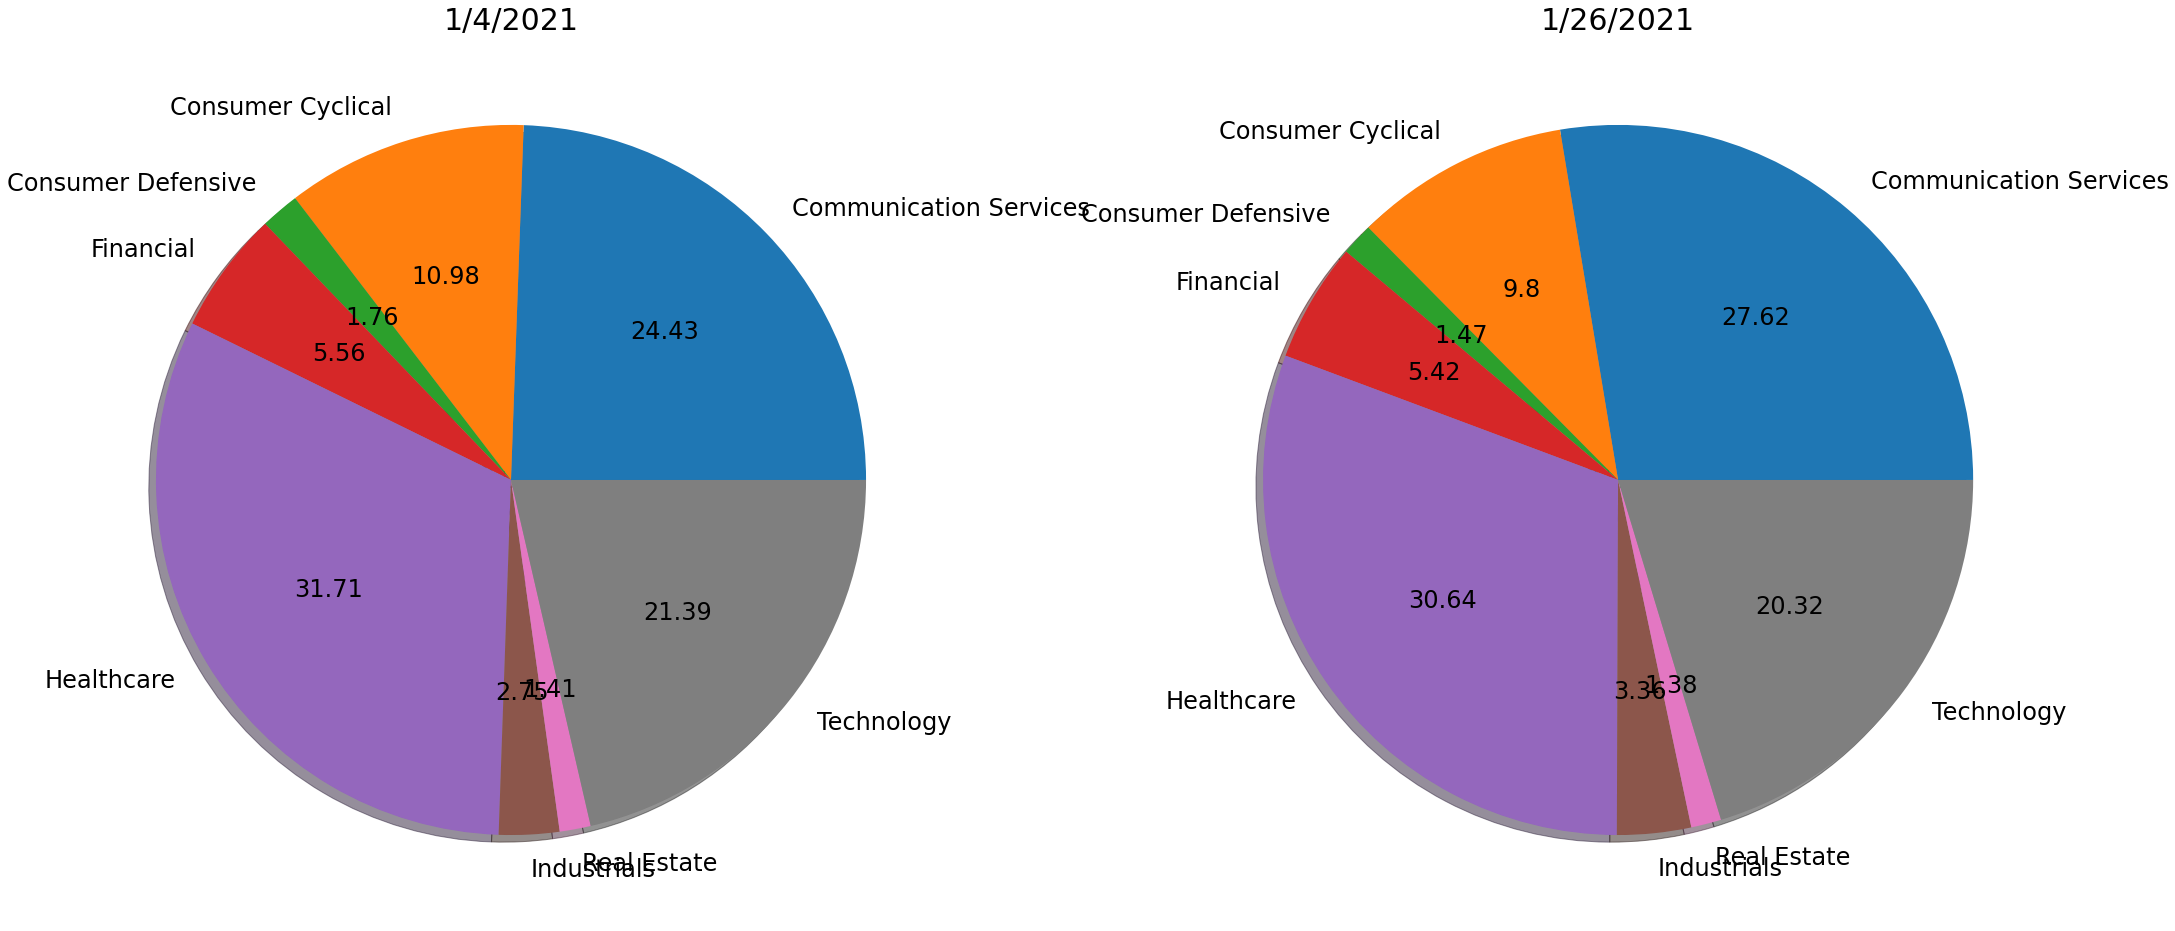

In [67]:
from ARK import *
def portfolio_diff(date1,date2,fund="ARKG"):
    '''
    Get a snapshot difference between 2 differing portfolio dates
    
    date1 = initial date
    date2 = final date
    fund = which of the 5 ark funds (ARKQ,ARKW,ARKK,ARKF,ARKG)
    '''
    
    if len(date1)<6:
        date1 += "/2021"
    if len(date2)<6:
        date2 += "/2021"
    
    subset1 = df[(df['fund']==fund) & (df['date']==date1)]
    subset2 = df[(df['fund']==fund) & (df['date']==date2)]

    sectors = subset1['sector'].append(subset2['sector']).unique() #Unique sectors among the 2 requested queries

    subset2_diversity = subset2.groupby('sector').sum()['weight']

    def autopct_layout(val):
        import numpy as np
        return np.round(val,2)

    def pie_chart(subset,date):
        import matplotlib.pyplot as plt
        subset_diversity = subset.groupby('sector').sum()['weight']
        patches, texts, autotexts =  plt.pie(subset_diversity,labels=subset_diversity.index.to_list(),autopct=autopct_layout,shadow=True)
        for i in texts:
            i.set_fontsize(24) #Set font size of sector names
        for i in autotexts: 
            i.set_fontsize(24) #Set font size for the values
        plt.tight_layout()
        plt.title(str(date),fontsize=30)
        return subset_diversity

    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=(30,15))
    plt.subplot(1,2,1)
    a = pie_chart(subset1,date1)
    plt.subplot(1,2,2)
    b = pie_chart(subset2,date2)
    print("Change in sector investments comparing %s to %s (Negative = devesting out-of/ Positive = investing into)"%(date1,date2))
    display(b-a)
    return a,b #Return the differing portfolios

a,b = portfolio_diff('1/4',"1/26","ARKK")

# Ticker Lookup

With all this data, it would be nice to visualize ARK's stance in a position. Are they buying? Selling? How many shares?

--- This verions is not pushed into `ARK.py` because the DASH chart only needs the data ... here in jpynb matplotlib does the plotting

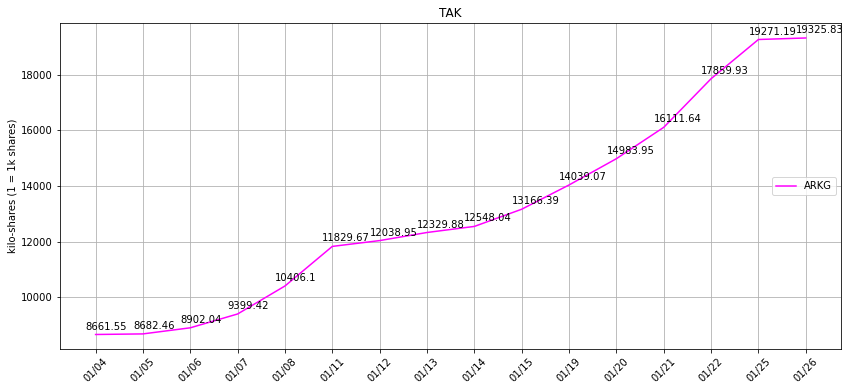

In [64]:
from ARK import *
def ticker_lookup(tickers,together=True,funds=None,return_plot=False):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    import datetime
    import numpy as np
    
    df = see_data() #Grab all data in ARKFund.db
    df['date'] = df['date'].astype('datetime64[ns]') #Convert date to datetime object so data can be sorted
    df = df.sort_values(['date','fund'],ascending=True) #Sort by ascending date

    #Compute a date axis
    earliest_date = df.iloc[0]['date']
    latest_date = df.iloc[-1]['date']
    xrange = pd.date_range(earliest_date,latest_date).date #Create a range of dates between start and end
    xrange = [datetime.datetime.strftime(i,"%m/%d/%Y") for i in xrange] #Convert datetime object to string "01/04/2021"
    
    plot_count = len(tickers) #How many plots per fund
    
    colors = ['magenta','k','cyan','g','r','dark green','pink','orange','yellow'] #Color pallete choices

    if funds == None: #If no fund is provided, search all 5 funds
        funds = ["ARKF","ARKG","ARKK","ARKQ","ARKW"]

    def log_reduction(val): #Reduce the y-axis by a factor of X
        import numpy as np
        reduced = [np.round(i/1000,2) for i in val] #Reduce share size by factor of 1000
        return reduced
    def timestamp_to_MonthDay(lst): #Convert "2021-01-14 00:00:00" to "01/14" for all elements in a list
        return [i.strftime("%m/%d") for i in lst]
    
    fund_label = []
    dates_vals = []
    if together:
        all_df = pd.DataFrame()
        i = 1

        for ticker in tickers:

            subset = df[df['ticker']==ticker.upper()].groupby('fund')
            fig = plt.figure(figsize=(14,6))
            #plt.subplot(1,plot_count,i) #This would stack plots horizontally ... the above does it veritcally
            j = 0

            for _,r in subset:
                shares = log_reduction(r['shares'])
                fund_label.append(r['fund'].unique()[0])
                dates = np.arange(0,len(shares)) #Create an arbitrary date axis from [0,n]
                if len(dates_vals) < len(dates): #If a fund opened a new position in a ticker ... it would start plotting at the beginning of time
                    dates_vals = dates #This sets the x-axis to be maximized correctly
                    dates_labels = timestamp_to_MonthDay(r['date']) #This converts the correct x-axis from [0,1,2,...,n] to appropriate labels
                else: #This case would be specifically if a fund opens a new position in the fund
                    dates = np.arange(len(dates_vals)-len(dates),len(dates_vals)) #The fund will not span the [0,1,2,...,n], but instead some [m,m+1,...,n]
                plt.plot(dates,shares,label=ticker,color=colors[j])
                for idx,Y in enumerate(shares):
                    plt.annotate(str(Y),xy=(dates[idx],Y),xytext=(-10,5),textcoords='offset points')
                j += 1
                all_df = all_df.append(r) #df to return in case its useful
                
            plt.title(ticker.upper())
            plt.xticks(dates_vals,rotation=45,labels=dates_labels) #Feed the arbirary axis with labels as the dates
            #plt.yticks([]) #Hide y-axis (already have the numbers on the data points) -- might turn this into a feature
            #For shared plot ... need y-axis and legend on all figures
            plt.ylabel("kilo-shares (1 = 1k shares)")
            plt.legend(labels=fund_label,loc="center right")
            plt.grid(axis='both')
            i += 1
    else:
        all_df = pd.DataFrame()
        i = 1
        fig = plt.figure(figsize=(14,6))
        plot_count = len(funds) #How many plots per fund

        for fund in funds:

            subset = df[df['fund']==fund.upper()]
            plt.subplot(1,plot_count,i)
            j = 0

            for ticker in tickers:
                r = subset[subset['ticker']==ticker.upper()]
                shares = log_reduction(r['shares'])
                dates = np.arange(0,len(shares)) #Create arbitrary date axis
                plt.plot(dates,shares,label=fund,color=colors[j])
                plt.xticks(dates_label,rotation=45,labels=dates_vals) #Feed in arbirary axis with labels as the dates
                for idx,Y in enumerate(shares):
                    plt.annotate(str(Y),xy=(idx,Y),xytext=(-10,5),textcoords='offset points')
                j += 1
                all_df = all_df.append(r) #df to return in case its useful

            plt.title(fund.upper())
            #plt.yticks([])
            plt.grid(axis='y')
            plt.tight_layout()
            if i == 1:
                plt.ylabel("kilo-shares (1 = 1k shares)")
            if i == plot_count:
                plt.legend(labels=tickers,loc="center right")
            i += 1
    if return_plot:
        return all_df,plt
    else:
        return all_df
_ = ticker_lookup(tickers = ['TAK'],together=True,funds=False,return_plot=False)


# Dash Applet

Here is the full code to create `app.py`

In [10]:
%%writefile app.py
import dash
import plotly
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output, State
from datetime import date, timedelta, datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import pandas as pd
import numpy as np

#To be able to import the ARK.py file and its modules, the directory needs to be added to PATH
import os
import sys

path = r'C:\Users\Brandon\Desktop\ARK Fund CSV Files'
module_path = os.path.abspath(path)
if module_path not in sys.path:
    sys.path.append(module_path)

#Now import ARK.py functions
from ARK import *

def start_up():
    '''
    Wrapper function to execute updating of database & tables
    '''
    set_dir(path) #Set directory

    #Before loading the applet -- Run the main function
    df_today,sectors,changes,_,_,alerts = update_arkfund(display_changes=False,manual_update=False) #Leaving `path` argument as default

    #Grab new/close position log files
    new = pd.read_csv(r"Logs\new_positions.csv") #Load in the full log file of new positions
    closed = pd.read_csv(r"Logs\closed_positions.csv") # --------- of the closed positions

    #Sort the changes df by ticker
    changes = changes.sort_values(by='ticker')

    #Remove unnecessary start vs end date columns for Changes & Alerts
    current_trading_session = changes['end_date'].iloc[0] #Grab the trading session info for reference
    current_trading_session = str(current_trading_session)[:10] #Truncate to YYYY-MM-DD from the original datetime64 obj.
    changes = changes.drop(['start_date','end_date'],axis=1)
    alerts = alerts.drop(['start_date','end_date'],axis=1)

    df = see_data() #Load all of ARKFund.db as df

    if df_today.empty: #If this script runs without loading a some data
        df_today = df[df['date']==df['date'].iloc[-1]]
    return df_today,sectors,changes,alerts,df,current_trading_session,new,closed

df_today,sectors,changes,alerts,df,current_trading_session,new,closed = start_up() #Run on start up of dash app
    
#Load in dash app with external CSS elements
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

#Define some theme settings
colors = {
    'background': '#111111',
    'text': '#7FDBFF',
    'button':'#D6D8DC',
    'sell': '#ff6666',
    'buy': '#99ff99',
    'big_buy': '#00ff00',
    'big_sell': '#ff4d4d',
    }

fund_colors = {
    'ARKK': '#33adff', #Fund 1 - Steel blue
    'ARKQ': '#ffaa80', #Fund 2 - Tan
    'ARKW': '#deb0ff', #Fund 3 - light purple
    'ARKG': '#cccc00', #Fund 4 - Yucky Yellow (LOL)
    'ARKF': '#46e4f0', #Fund 5 - Teal
}

#Define formatting for tables (https://dash.plotly.com/datatable/conditional-formatting)
base_table_formatting=[ #Base formatting that is going to be similar across all tables
        {
            'if': {
                'row_index': 'odd',  # number | 'odd' | 'even'
            },
            'backgroundColor': 'rgba(175,175,175,0.7)',
        },    
    
        {
            'if': {
                'column_type': 'text'  # 'text' | 'any' | 'datetime' | 'numeric'
            },
            'textAlign': 'left'
        },
    
        {
            'if': {
                'column_type': 'numeric'  # 'text' | 'any' | 'datetime' | 'numeric'
            },
            'textAlign': 'center'
        },

        {
            'if': {
                'state': 'active'  # 'active' | 'selected'
            },
           'backgroundColor': 'rgba(0, 116, 217, 0.3)',
           'border': '1px solid rgb(0, 116, 217)'
        },
    
    ]
for i,j in fund_colors.items():
    base_table_formatting.append(
        {
            'if': {
                'filter_query': '{fund} = %s'%i  # If fund is equal to i-th key
            },
           'backgroundColor': '%s'%j, #Set color to the j-th value
        },
    )

#Define formatting for transaction table
transaction_table_formatting = base_table_formatting.copy()
transaction_table_formatting.append(
        {
            'if': {
                'filter_query': '{change_in_shares} > 0', # If transaction is positive
                'column_id': 'change_in_shares'
            },
            'backgroundColor': colors['buy'] #Color as buy
        }
)
transaction_table_formatting.append(
        {
            'if': {
                'filter_query': '{change_in_shares} < 0', # If transaction is negative
                'column_id': 'change_in_shares'
            },
            'backgroundColor': colors['sell'] #Color as sell
        },    
)

#Define formatting for changes table
changes_table_formatting = base_table_formatting.copy()
changes_table_formatting.append(
        {
            'if': {
                'filter_query': '{change} > 0', # If change is positive -- buy color
                'column_id': ['change','percent_change']
            },
            'backgroundColor': colors['buy']
        }
)
changes_table_formatting.append(
        {
            'if': {
                'filter_query': '{change} < 0', # If change is negative -- sell color
                'column_id': ['change','percent_change']
            },
            'backgroundColor': colors['sell']
        },  
)


#Define formatting for alerts table
alerts_table_formatting = base_table_formatting.copy()
alerts_table_formatting.append(
        {
            'if': {
                'filter_query': '{change} > 0', # If change is positive -- buy color
                'column_id': ['change','percent_change']
            },
            'backgroundColor': colors['buy']
        }
)
alerts_table_formatting.append(    
        {
            'if': {
                'filter_query': '{change} < 0', # If change is negative -- sell color
                'column_id': ['change','percent_change']
            },
            'backgroundColor': colors['sell']
        },
)

min_date = date(2021,1,4) #Hard code ... this is the earliest date of data in ARKFund.db 
max_str = datetime.strptime(df['date'].iloc[-1], '%m/%d/%Y') #Define max date as the most current date in the database
max_date = date(max_str.year,max_str.month,max_str.day) #Convert to datetime obj

app.layout = html.Div(children=[
    #Row 1    
    dbc.Row([ 
        dbc.Col(
            #Date selector
            html.Div([
                dcc.DatePickerRange(
                    id='date1',
                    min_date_allowed=min_date,
                    max_date_allowed=max_date+timedelta(1),
                    initial_visible_month=date.today(),
                    clearable=True,
                    start_date=min_date, #Initialize as 1/4
                    end_date=max_date #Initialize as today's date
                )
            ]),className='two columns',align='start'
        ),
        dbc.Col(
            html.Div([
                dcc.Dropdown(  #Ticker search box
                    id = 'ticker_input',
                    options= [{'label': i, 'value': i} for i in df['ticker'].unique()],
                    value = "NNDM", #Default value
                    placeholder="Select a ticker", #display text if no value selected
                )
            ]),className='two columns',align='start'
        ),
        dbc.Col(
            html.Div([
                html.A(html.Button(id='update_db',children='Update Database',n_clicks=0),href='/') #Update database button
            ]),className='two columns',align='start'
        ),
        
#        dbc.Col(
#            html.Div([
#
#            ],className="One of four columns")),

#         dbc.Col(
#             html.Div([ #Update button
#                 html.Button(id='ticker_button',
#                             children='Update',
#                             n_clicks=0
#                 )
#             ],className='One of four columns')),
        
    ],no_gutters=True),

    
    #Row 2
    dbc.Row([

        #ticker table --- ticker specific transactions
        dbc.Col(
            html.Div([
                dcc.Graph(id='ticker_lookup_chart'), #Ticker_lookup chart
            ],className="six columns"),
        ),
            
        dbc.Col(
            html.Div([
                html.H1(id='textbox1',
                          children = "Ticker Transactions - "
                ),
                dash_table.DataTable(
                    id='transactions_table',
                    style_cell={'textAlign': 'left',
                                'font_family': 'Arial',
                                'font_size': '18px'},
                    style_as_list_view=True,
                    fixed_rows={'headers': True}, #Allow headers to follow scrolling -- Vertical scrolling
                    style_table={'height': 550, # defaults to 500 
                                'overflowX': 'auto'},  #Horizontal scrolling
                    style_data_conditional= transaction_table_formatting #Define all the color-coding
                )
            ]),className='six columns')       
    ]),
    
    #Line break
    html.Hr(),
    
    #Row 3
    html.Div([
            html.Div([
                html.H1("Alerts for session - " + current_trading_session),
                dash_table.DataTable(
                    id='alerts_table',
                    style_cell={'textAlign': 'left',
                               'font_family': 'Arial',
                                'font_size': '18px'},
                    columns=[{"name": i, "id": i} for i in alerts.columns],
                    data=alerts.to_dict('records'),
                    style_as_list_view=True,
                    style_table={'overflowX': 'auto'},
                    style_data_conditional=alerts_table_formatting #Define all the color-coding
                )
            ],className='six columns')
    ],className='row'),
    
    #Row 4
    html.Div([
        
            #Changes table
            html.Div([
                html.H1("Changes in last trading session - " + current_trading_session),
                dash_table.DataTable(
                    id='changes_table',
                        style_data={
                            'whiteSpace': 'normal',
                            'height': 'auto',
                            'lineHeight': '15px'
                        },
                    style_cell={'textAlign': 'left',
                                'font_family': 'Arial',
                                'font_size': '18px'},
                    columns=[{"name": i, "id": i} for i in changes.columns],
                    data=changes.to_dict('records'),
                    style_as_list_view=True,
                    fixed_rows={'headers': True}, #Allow headers to follow scrolling -- Vertical scrolling
                    style_table={
                                #'height': 600, # defaults to 500 
                                'overflowX': 'auto' #Horizontal scrolling
                                },  
                    style_data_conditional=changes_table_formatting #Define all the color-coding
                )
            ],className='six columns'),
        
            #New table
            html.Div([html.H1("Recently Opened Positions"),
                dash_table.DataTable(
                    id='new_table',
                    style_cell={'textAlign': 'left',
                               'font_family': 'Arial',
                                'font_size': '18px'},
                    columns=[{"name": i, "id": i} for i in new.columns],
                    data=new.to_dict('records'),
                    style_as_list_view=True,
                    style_data_conditional = base_table_formatting
                )
            ],className='three columns'),
        
            #Closed table
            html.Div([html.H1("Recently Closed Positions"),
                dash_table.DataTable(
                    id='closed_table',
                    style_cell={'textAlign': 'left',
                               'font_family': 'Arial',
                                'font_size': '18px'},
                    columns=[{"name": i, "id": i} for i in closed.columns],
                    data=closed.to_dict('records'),
                    style_as_list_view=True,
                    style_data_conditional = base_table_formatting
                )
            ],className='three columns'),
    ],className='row')
    
]) #Close app.layout

########################################################################################
############      Define Callback functions        #####################################

#Call back for ticker chart creation
@app.callback([Output("ticker_lookup_chart","figure")],
              [Input("date1","start_date"),Input("date1","end_date"),Input("ticker_input",'value')],
              )
def update_ticker_lookup_chart(date1,date2,ticker):
    lookup = ticker_lookup_dash(ticker,date1,date2) #lookup is a pandas dataframe
    price_end_date = datetime.strptime(date2, '%Y-%m-%d') + timedelta(1) #Convert date2 into datetime obj and add 1 day --- yfinance doesn't grab "1/25" if the endate is "1/25", it grabs "1/24" as the final entry
    price = yf.Ticker(ticker).history(start=date1,end=price_end_date) #Grab ticker's closing prices
    ticker_dates = list(price['Close'].index.astype("str").str.replace("-","/").str.extract(r'/(\d{2}/\d{2})')[0]) #dates to the prices (conversion from "2021-01-04TCU00:00:00" to "01/04")
    ticker_close = np.round(price['Close'].values.astype(float),2) #closing price -- round to 2 decimals
    
    #Create figure
    fig = make_subplots(specs=[[{"secondary_y": True}]]) #Create figure
    #Create line for price
    fig.add_trace(
            go.Scatter(
                x=ticker_dates,
                y=ticker_close, 
                name="Price",
                line=dict(color="#FFC300")), #Define a color for the price line
        secondary_y=True, #Plot on secondary axis
    )
    
    for fund,dat in lookup.groupby('fund'):
        fig.add_trace(
                go.Scatter(
                    x=dat['date'], #x-val
                    y=dat['shares'], #y-val
                    mode='lines+markers', #plot as line + dots
                    name=fund
                ),
            secondary_y=False #Plot on primary axis
         ) #Name each line for legend plotting
    

    #Define y & secondary-y axis names
    
    fig.update_yaxes(title_text="Shares", secondary_y=False)
    fig.update_yaxes(title_text="Closing Price ($)", secondary_y=True)
    
    fig.update_layout(
        title={
            'text': ticker,
            'y':0.9, #percent of y-relative location
            'x':0.18, #percent of x-relative location
            'xanchor': 'center',
            'yanchor': 'top',
            'font_size': 40
        },
        #xaxis_title="X Axis Title",
        #yaxis_title="shares",
        height=600,
        #autosize=True, #Automatically determines width and height for the chart ... but it not great
#        transition = {
#            'easing':'elastic' #The transition animation when chart updates
#        },
        legend_title="Funds: ",
        showlegend=True, #Show legend even if there is only 1 line
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
            ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            bgcolor="LightBlue",
            bordercolor="Black",
            borderwidth=1
        ),
        dragmode='pan', #Set default mode to pan instead of zoom
        hovermode="x unified", #to cause the label to appear for ALL lines based on the x-axis location hover (https://plotly.com/python/hover-text-and-formatting/)
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        )
    )

    return [fig] #Needs to be returned as a list

#Callback for Transaction Table
@app.callback([Output("textbox1","children"),Output('transactions_table','columns'),Output('transactions_table','data')],
              [Input("date1","start_date"),Input("date1","end_date"),Input("ticker_input",'value')]
             )
def update_textbox_transaction_log(start_date,end_date,ticker):
    if ticker is None:
        output_string = ["Select a ticker"] #Return generic statement
        columns = [] #Return no data
    else:
        output_string = ["Ticker Transaction Log - " + ticker] #Return specific ticker info
        transaction_log = compute_transactions(ticker,start_date,end_date)
        
        #Convert date column from datetime64[ns] to str & grab only YYYY-MM-DD
        transaction_log['date'] = transaction_log['date'].astype('str')
        transaction_log['date'] = transaction_log['date'].str.extract(r'(\d{4}-\d{2}-\d{2})')

        columns=[{"name": i, "id": i} for i in transaction_log.columns] #Return specific ticker data table
        data=transaction_log.to_dict('records')
    return output_string,columns,data

#Callback for reloading app
@app.callback([Output("update_db","children")], #This is just a dummy output variable ... not going to change it
              [Input("update_db","n_clicks"),Input("ticker_input","value")]
             )
def reload_app(n_clicks,ticker):
    if n_clicks > 0:
        n_clicks = 0 #Reset counter
        df_today,sectors,changes,alerts,df,current_trading_session,new,closed = start_up() #Run start_up function
        text = ['Updating...']
    else:
        text = ['Update Database']
    return text

if __name__ == '__main__':
    app.run_server(debug=True,port=8050)

Overwriting app.py
